In [4]:
%load_ext autoreload

%autoreload 2

/home/aritra/.local/share/pipx/venvs/jupyterlab/lib/python3.12/site-packages/hist/basehist.py:417: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


11
[0.0e+00 1.0e+01 2.0e+01 4.0e+01 6.0e+01 8.0e+01 1.0e+02 1.2e+02 1.4e+02
 1.6e+02 2.0e+02 1.3e+04]
21
[0.0e+00 5.0e+00 1.0e+01 1.5e+01 2.0e+01 3.0e+01 4.0e+01 5.0e+01 6.0e+01
 7.0e+01 8.0e+01 9.0e+01 1.0e+02 1.1e+02 1.2e+02 1.3e+02 1.4e+02 1.5e+02
 1.6e+02 2.0e+02 5.0e+02 1.3e+04]
Signal Binning created
Detector Binning created
shape of you (84,)


In [34]:
import hist
import pickle as pkl
from unfold_utils.unfolder import *
import ipywidgets as widgets
from IPython.display import display
from unfold_utils.draw_tools import * 
from unfold_utils.integrate_and_rebin import *

title_list = [ r"$p_T$ 200-290 GeV",  r"$p_T$ 290-400 GeV",  r"$p_T$ 400-480 GeV",  r"$p_T$ 480-$\infty$ GeV"]
color_pt = ["#1f77b4", "#d62728", "#2ca02c", "#ff7f0e"]
ww16 =  (36330  * 75.95) /(15688000.0 + 15054400.0)

wz16 =  (36330  * 27.6)/( 7584000.0 + 7584000.0)

zz16 = (36330  * 12.17)/( 712000.0 + 1151000.0)

ww17 = (36330  * 75.95)/15154000.0
wz17 = (41480 * 27.6)/7789250.0
zz17 = (41480* 12.17 )/2022000.0

ww18 = (41480 * 75.95	)/9983800.0
wz18 = (41480 * 27.6)/10075000.0
zz18 = (41480* 12.17 )/1936000.0


f_prefix = 'plots/zjet/'

class Unfold_driver:
    def __init__(self, files, closure = False, groomed = True, regularization = 'None'):

        self.groomed = groomed
        self.regularization = regularization
        self.closure = closure
        self.herwig =  'herwig' in files
        self.jk =  'jackknife' in files
        self.bg =  'backgrounds' in files
        
        

        with open(files['pythia'], "rb") as f:
            output_pythia= pkl.load( f )
        with open(files['data'], "rb") as f:
            output_data = pkl.load( f )
        if self.herwig:
            with open(files["herwig"], "rb") as f:
                output_herwig = pkl.load( f )
        if self.bg:
            with open(files["backgrounds"], "rb") as f:
                output_bg= pkl.load( f )
        if self.jk:
            with open(files["mc_jackknife"], "rb") as f:
                output_jk= pkl.load( f )

        if not self.groomed: ### Ungroomed
            self.resp_matrix_4d = output_pythia['response_matrix_u']
            self.input_data = output_data['ptjet_mjet_u_reco']
            self.fakes = output_pythia['fakes_u']
            self.misses = output_pythia['misses_u']
            if self.bg:
                self.hist_bg = output_bg['response_matrix_u'].project('dataset','ptreco','mreco')
            self.resp_matrix_pythia = self.resp_matrix_4d
            if self.herwig:
                self.resp_matrix_4d_herwig  = output_herwig['response_matrix_u'][{'systematic':['herwig']}]
                self.fakes_herwig = output_herwig['fakes_u']
                self.misses_herwig = output_herwig['misses_u']

            self.edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,
                          120, 130, 140, 150, 160, 180, 200, 500, 13000]

            self.edges_gen = [0, 20, 40, 60, 80, 100, 120, 140, 160, 200, 13000]

        else: ## Groomed
                                    
            self.resp_matrix_4d = output_pythia['response_matrix_g']
            self.input_data = output_data['ptjet_mjet_g_reco']
            self.fakes = output_pythia['fakes_g']
            self.misses = output_pythia['misses_g']
            if self.bg:
                self.hist_bg = output_bg['response_matrix_u'].project('dataset','ptreco','mreco')
            self.resp_matrix_pythia = self.resp_matrix_4d
            
            if self.herwig:
                self.resp_matrix_4d_herwig = output_herwig['response_matrix_g'][{'systematic':['herwig']}]
                self.fakes_herwig = output_herwig['fakes_g']
                self.misses_herwig = output_herwig['misses_g']
            # self.edges = [0, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,
            #               120, 130, 140, 150, 160, 180, 200, 500, 13000]
            
            # self.edges_gen = [0,5,  10, 20, 40, 60, 80, 100, 120, 140, 160, 200, 13000]

            self.edges = [ 0, 5, 10 , 15,  20, 30, 40, 50, 60, 70, 80, 90, 100, 110,
                          120, 130, 140, 150, 160, 180, 200, 500, 13000]
            
            self.edges_gen = [0, 10, 20, 40, 60, 80, 100, 120, 140, 160, 200, 13000]


        self.resp_matrix_4d = rebin_hist(self.resp_matrix_4d, 'mreco',self.edges )
        
        self.resp_matrix_4d = rebin_hist(self.resp_matrix_4d, 'mgen',self.edges_gen )
        
        self.resp_matrix_4d_herwig = rebin_hist(self.resp_matrix_4d_herwig, 'mreco',self.edges )
        self.resp_matrix_4d_herwig = rebin_hist(self.resp_matrix_4d_herwig, 'mgen',self.edges_gen )
        self.fakes =  rebin_hist(self.fakes, 'mreco',self.edges )
        self.misses = rebin_hist(self.misses, 'mgen',self.edges_gen )
        self.hist_bg = rebin_hist(self.hist_bg, 'mreco',self.edges )
        self.input_data = rebin_hist(self.input_data, 'mreco',self.edges)


        self.ptreco_center = self.resp_matrix_4d.axes['ptreco'].centers
        self.ptreco_width = self.resp_matrix_4d.axes['ptreco'].widths
        self.ptreco_edge = self.resp_matrix_4d.axes['ptreco'].edges
        
        self.ptgen_center = self.resp_matrix_4d.axes['ptgen'].centers
        self.ptgen_width = self.resp_matrix_4d.axes['ptgen'].widths
        self.ptgen_edge = self.resp_matrix_4d.axes['ptgen'].edges
        self.mreco_center = self.resp_matrix_4d.axes['mreco'].centers
        self.mreco_edge = self.resp_matrix_4d.axes['mreco'].edges
        self.mgen_center = self.resp_matrix_4d.axes['mgen'].centers
        
        self.mreco_width = self.resp_matrix_4d.axes['mreco'].widths
        self.mgen_width = self.resp_matrix_4d.axes['mgen'].widths
        self.mgen_edge = self.resp_matrix_4d.axes['mgen'].edges

        self.define_jes_lists()
        self.create_systematic_variations()

        


    def initiate_unfolder(self):
        self.unfolder = Unfolder(self.input_data, 
                    self.resp_matrix_4d[{'systematic':'nominal'}] ,
                    #resp_matrix_4d_jk,
                    fakes = self.fakes,
                    misses = self.misses,
                    #backgrounds = {"ww": ww_bg, "wz":wz_bg, "zz": zz_bg},
                    systematics = {'JES_AbsoluteMPFBiasUp': self.resp_matrix_4d[{'systematic':'JES_AbsoluteMPFBiasUp'}].project('ptgen', 'mgen', 'ptreco', 'mreco').values()  },
                    #systematics = sys_matrix_dic,
                    #systematics= None,
                    #systematics = jes_sys_list_up,
                    closure = False,
                    groomed = self.groomed,
                    is_uf = True,
                    merge = False,
                    normalised_xs = True,
                    do_syst = True,
                    discard_low_bins = False,
                    regularisation= 'ScanSURE',
                    do_norm = False
                           )

        self.unfolder_dn = Unfolder(self.input_data, 
                    self.resp_matrix_4d[{'systematic':'nominal'}] ,
                    #resp_matrix_4d_jk,
                    fakes = self.fakes,
                    misses = self.misses,
                    #backgrounds = {"ww": ww_bg, "wz":wz_bg, "zz": zz_bg},
                    systematics = {'JES_AbsoluteMPFBiasDown': self.resp_matrix_4d[{'systematic':'JES_AbsoluteMPFBiasDown'}].project('ptgen', 'mgen', 'ptreco', 'mreco').values()  },
                    #systematics = sys_matrix_dic,
                    #systematics= None,
                    #systematics = jes_sys_list_up,
                    closure = False,
                    groomed = self.groomed,
                    is_uf = True,
                    merge = False,
                    normalised_xs = True,
                    do_syst = True,
                    discard_low_bins = False,
                    regularisation= 'ScanSURE',
                    do_norm = False
                           )
        

        
        
        

    def define_jes_lists(self):

        """
        Define the correlation factors and the list of systematic variations
        """
        self.correlation_dic = {
            'JES_AbsoluteMPFBias': 1,
            'JES_AbsoluteScale': 1,
            'JES_AbsoluteStat': 0,
            'JES_FlavorQCD': 1,
            'JES_Fragmentation': 1,
            'JES_PileUpDataMC': 0.5,
            'JES_PileUpPtBB': 0.5,
            'JES_PileUpPtEC1': 0.5,
            'JES_PileUpPtEC2': 0.5,
            'JES_PileUpPtHF': 0.5,
            'JES_PileUpPtRef': 0.5,
            'JES_RelativeFSR': 0.5,
            'JES_RelativeJEREC1': 0,
            'JES_RelativeJEREC2': 0,
            'JES_RelativeJERHF': 0.5,
            'JES_RelativePtBB': 0.5,
            'JES_RelativePtEC1': 0,
            'JES_RelativePtEC2': 0,
            'JES_RelativePtHF': 0.5,
            'JES_RelativeBal': 0.5,
            'JES_RelativeSample': 0,
            'JES_RelativeStatEC': 0,
            'JES_RelativeStatFSR': 0,
            'JES_RelativeStatHF': 0,
            'JES_SinglePionECAL': 1,
            'JES_SinglePionHCAL': 1,
            'JES_TimePtEta': 0
        }
        
        self.jes_sys_list = ['JES_AbsoluteMPFBiasUp', 'JES_AbsoluteMPFBiasDown', 'JES_AbsoluteScaleUp', 'JES_AbsoluteScaleDown',
                        'JES_AbsoluteStatUp', 'JES_AbsoluteStatDown', 'JES_FlavorQCDUp', 'JES_FlavorQCDDown', 'JES_FragmentationUp',
                        'JES_FragmentationDown', 'JES_PileUpDataMCUp', 'JES_PileUpDataMCDown', 'JES_PileUpPtBBUp', 'JES_PileUpPtBBDown',
                        'JES_PileUpPtEC1Up', 'JES_PileUpPtEC1Down', 'JES_PileUpPtEC2Up', 'JES_PileUpPtEC2Down', 'JES_PileUpPtHFUp', 'JES_PileUpPtHFDown', 
                        'JES_PileUpPtRefUp', 'JES_PileUpPtRefDown', 'JES_RelativeFSRUp', 'JES_RelativeFSRDown', 'JES_RelativeJEREC1Up',
                        'JES_RelativeJEREC1Down', 'JES_RelativeJEREC2Up', 'JES_RelativeJEREC2Down', 'JES_RelativeJERHFUp', 'JES_RelativeJERHFDown',
                        'JES_RelativePtBBUp', 'JES_RelativePtBBDown', 'JES_RelativePtEC1Up', 'JES_RelativePtEC1Down', 'JES_RelativePtEC2Up', 'JES_RelativePtEC2Down',
                        'JES_RelativePtHFUp', 'JES_RelativePtHFDown', 'JES_RelativeBalUp', 'JES_RelativeBalDown', 'JES_RelativeSampleUp', 'JES_RelativeSampleDown', 
                        'JES_RelativeStatECUp', 'JES_RelativeStatECDown', 'JES_RelativeStatFSRUp', 'JES_RelativeStatFSRDown', 'JES_RelativeStatHFUp', 'JES_RelativeStatHFDown',
                        'JES_SinglePionECALUp', 'JES_SinglePionECALDown', 'JES_SinglePionHCALUp', 'JES_SinglePionHCALDown', 'JES_TimePtEtaUp', 'JES_TimePtEtaDown']
        
        
        self.non_jes_sys_list = ['nominal', 'puUp', 'puDown', 'elerecoUp', 'elerecoDown',
                            'eleidUp', 'eleidDown', 'eletrigUp', 'eletrigDown', 'murecoUp',
                            'murecoDown', 'muidUp', 'muidDown', 'mutrigUp', 'mutrigDown', 'muisoUp', 'muisoDown', 'pdfUp',
                            'pdfDown', 'q2Up', 'q2Down', 'prefiringUp', 'prefiringDown', 
                            'JERUp', 'JERDown', 'JMRUp', 'JMRDown', 'JMSUp', 'JMSDown']
        
        
        self.non_jes_sys_list_up = [sys for sys in self.non_jes_sys_list if sys[-2:] == 'Up' ]
        self.non_jes_sys_list_down = [sys for sys in self.non_jes_sys_list if sys[-4:] == 'Down' ]
        
        self.jes_sys_list_up = [sys for sys in self.jes_sys_list if sys[-2:] == 'Up' ]
        self.jes_sys_list_down = [sys for sys in self.jes_sys_list if sys[-4:] == 'Down' ]

    def create_systematic_variations(self):

        
        """
        Create the dictionary of matrices for each systematic variations
        """
        sys_matrix_dic = {}
        
        for sys in self.jes_sys_list_up:
            m_nom_2016 = self.resp_matrix_4d[['UL16NanoAODv9', 'UL16NanoAODAPVv9'], ..., 'nominal'].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            m_nom_2017 = self.resp_matrix_4d[['UL17NanoAODv9', ], ..., 'nominal'].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            m_nom_2018 = self.resp_matrix_4d[['UL18NanoAODv9', ], ..., 'nominal'].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            
            m_sys_2016 = self.resp_matrix_4d[['UL16NanoAODv9', 'UL16NanoAODAPVv9'], ..., sys].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            m_sys_2017 = self.resp_matrix_4d[['UL17NanoAODv9', ], ..., sys].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            m_sys_2018 = self.resp_matrix_4d[['UL18NanoAODv9', ], ..., sys].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            
            
            m_var_2016 = m_sys_2016 + m_nom_2017 + m_nom_2018
            m_var_2017 = m_nom_2016 + m_sys_2017 + m_nom_2018
            m_var_2018 = m_nom_2016 + m_nom_2017 + m_sys_2018
            
            
            rho = 0.5 ## correlation factor
            
            sigma_2016 = m_sys_2016 - m_nom_2016
            sigma_2017 = m_sys_2017 - m_nom_2017
            sigma_2018 = m_sys_2018 - m_nom_2018
            
            sigma_corr = rho*sigma_2016 + rho*sigma_2017 + rho*sigma_2018
            
            sigma_uncorr_2016 = (1-rho)*sigma_2016
            sigma_uncorr_2017 = (1-rho)*sigma_2017
            sigma_uncorr_2018 = (1-rho)*sigma_2018
            
            m_nom =  m_nom_2016 + m_nom_2017 + m_nom_2018
            m_corr = m_nom + sigma_corr
            
            m_uncorr_2016 = m_nom + sigma_uncorr_2016
            
            m_uncorr_2017 = m_nom + sigma_uncorr_2017
        
            m_uncorr_2018 = m_nom + sigma_uncorr_2018
        
            
        
            sys_matrix_dic[sys+'_corr'] = m_corr
            sys_matrix_dic[sys+'_uncorr_2016'] = m_uncorr_2016
            sys_matrix_dic[sys+'_uncorr_2017'] = m_uncorr_2017
            sys_matrix_dic[sys+'_uncorr_2018'] = m_uncorr_2018
            
        non_jes_sys_matrix_dic = {}
        for sys in self.non_jes_sys_list_up:
            sys_matrix_dic[sys] = self.resp_matrix_4d[ ..., sys].project('ptgen','mgen','ptreco','mreco').values()
            non_jes_sys_matrix_dic[sys] = self.resp_matrix_4d[ ..., sys].project('ptgen','mgen','ptreco','mreco').values()
        
        
        
        sys_matrix_dic_down = {}
        for sys in self.jes_sys_list_down:
            m_nom_2016 = self.resp_matrix_4d[['UL16NanoAODv9', 'UL16NanoAODAPVv9'], ..., 'nominal'].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            m_nom_2017 = self.resp_matrix_4d[['UL17NanoAODv9', ], ..., 'nominal'].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            m_nom_2018 = self.resp_matrix_4d[['UL18NanoAODv9', ], ..., 'nominal'].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            
            m_sys_2016 = self.resp_matrix_4d[['UL16NanoAODv9', 'UL16NanoAODAPVv9'], ..., sys].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            m_sys_2017 = self.resp_matrix_4d[['UL17NanoAODv9', ], ..., sys].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            m_sys_2018 = self.resp_matrix_4d[['UL18NanoAODv9', ], ..., sys].project('ptgen', 'mgen', 'ptreco', 'mreco').values()
            
            
            m_var_2016 = m_sys_2016 + m_nom_2017 + m_nom_2018
            m_var_2017 = m_nom_2016 + m_sys_2017 + m_nom_2018
            m_var_2018 = m_nom_2016 + m_nom_2017 + m_sys_2018
            
            
            rho = 0.5 ## correlation factor
            
            sigma_2016 = m_sys_2016 - m_nom_2016
            sigma_2017 = m_sys_2017 - m_nom_2017
            sigma_2018 = m_sys_2018 - m_nom_2018
            
            sigma_corr = rho*sigma_2016 + rho*sigma_2017 + rho*sigma_2018
            
            sigma_uncorr_2016 = (1-rho)*sigma_2016
            sigma_uncorr_2017 = (1-rho)*sigma_2017
            sigma_uncorr_2018 = (1-rho)*sigma_2018
            
            m_nom =  m_nom_2016 + m_nom_2017 + m_nom_2018
            m_corr = m_nom + sigma_corr
            
            m_uncorr_2016 = m_nom + sigma_uncorr_2016
            
            m_uncorr_2017 = m_nom + sigma_uncorr_2017
        
            m_uncorr_2018 = m_nom + sigma_uncorr_2018
        
            
        
            sys_matrix_dic_down[sys+'_corr'] = m_corr
            sys_matrix_dic_down[sys+'_uncorr_2016'] = m_uncorr_2016
            sys_matrix_dic_down[sys+'_uncorr_2017'] = m_uncorr_2017
            sys_matrix_dic_down[sys+'_uncorr_2018'] = m_uncorr_2018
            
        non_jes_sys_matrix_dic_down = {}
        for sys in self.non_jes_sys_list_down:
            sys_matrix_dic_down[sys] = self.resp_matrix_4d[ ..., sys].project('ptgen','mgen','ptreco','mreco').values()
            non_jes_sys_matrix_dic_down[sys] = self.resp_matrix_4d[ ..., sys].project('ptgen','mgen','ptreco','mreco').values()

        self.sys_matrix_dic = sys_matrix_dic
        self.sys_matrix_dic_down = sys_matrix_dic_down

        
        
        
                    

        

In [35]:
files = {'pythia': 'latest_pkl/pythia_syst_0703.pkl',
        'herwig': "latest_pkl/herwig_0703.pkl",
        'mc_jackknife':'latest_pkl/pythia__0703_jk.pkl',
        'backgrounds':'latest_pkl/backgrounds_0703.pkl',
         'data':"latest_pkl/data_combined_0703.pkl"
        }
unfold_driver = Unfold_driver(files)
unfold_driver.initiate_unfolder()

11
[0.0e+00 1.0e+01 2.0e+01 4.0e+01 6.0e+01 8.0e+01 1.0e+02 1.2e+02 1.4e+02
 1.6e+02 2.0e+02 1.3e+04]
22
[0.0e+00 5.0e+00 1.0e+01 1.5e+01 2.0e+01 3.0e+01 4.0e+01 5.0e+01 6.0e+01
 7.0e+01 8.0e+01 9.0e+01 1.0e+02 1.1e+02 1.2e+02 1.3e+02 1.4e+02 1.5e+02
 1.6e+02 1.8e+02 2.0e+02 5.0e+02 1.3e+04]
Signal Binning created
Detector Binning created
shape of you (88,)
11
[0.0e+00 1.0e+01 2.0e+01 4.0e+01 6.0e+01 8.0e+01 1.0e+02 1.2e+02 1.4e+02
 1.6e+02 2.0e+02 1.3e+04]
22
[0.0e+00 5.0e+00 1.0e+01 1.5e+01 2.0e+01 3.0e+01 4.0e+01 5.0e+01 6.0e+01
 7.0e+01 8.0e+01 9.0e+01 1.0e+02 1.1e+02 1.2e+02 1.3e+02 1.4e+02 1.5e+02
 1.6e+02 1.8e+02 2.0e+02 5.0e+02 1.3e+04]
Signal Binning created
Detector Binning created
shape of you (88,)


Working until background subtractions
Unfolder object created
Regularisation USED ScanSURE
Tau value 3.4479234513090075e-06
Output Underflow 0.0, output overflow 0.0
261065.80682007468
423113.42383632145


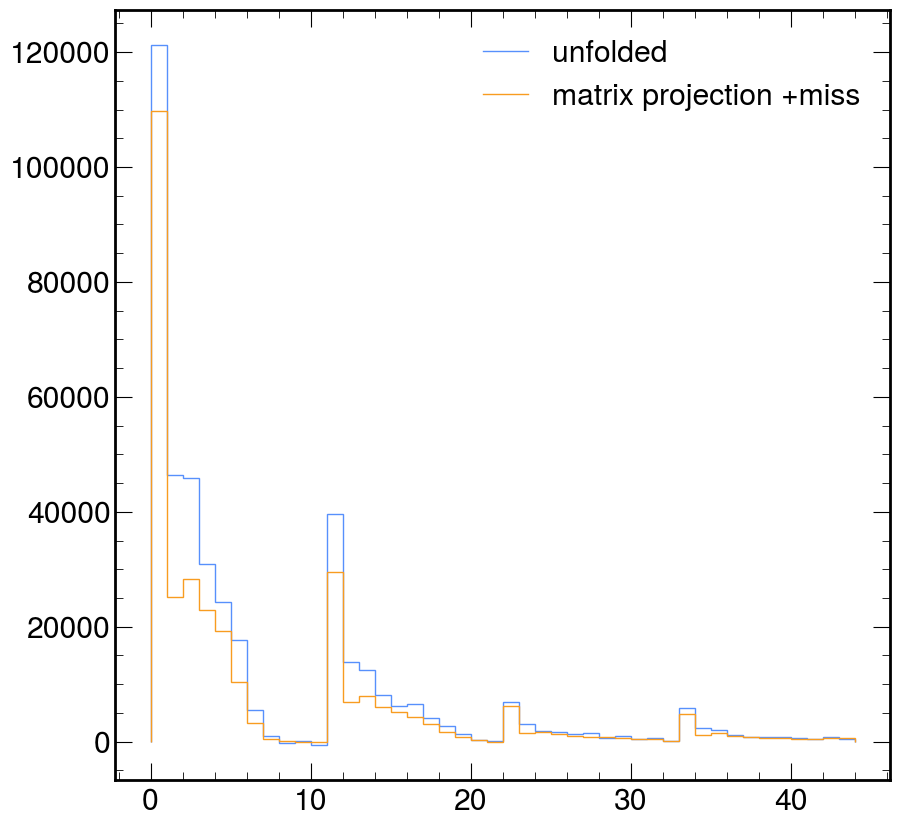

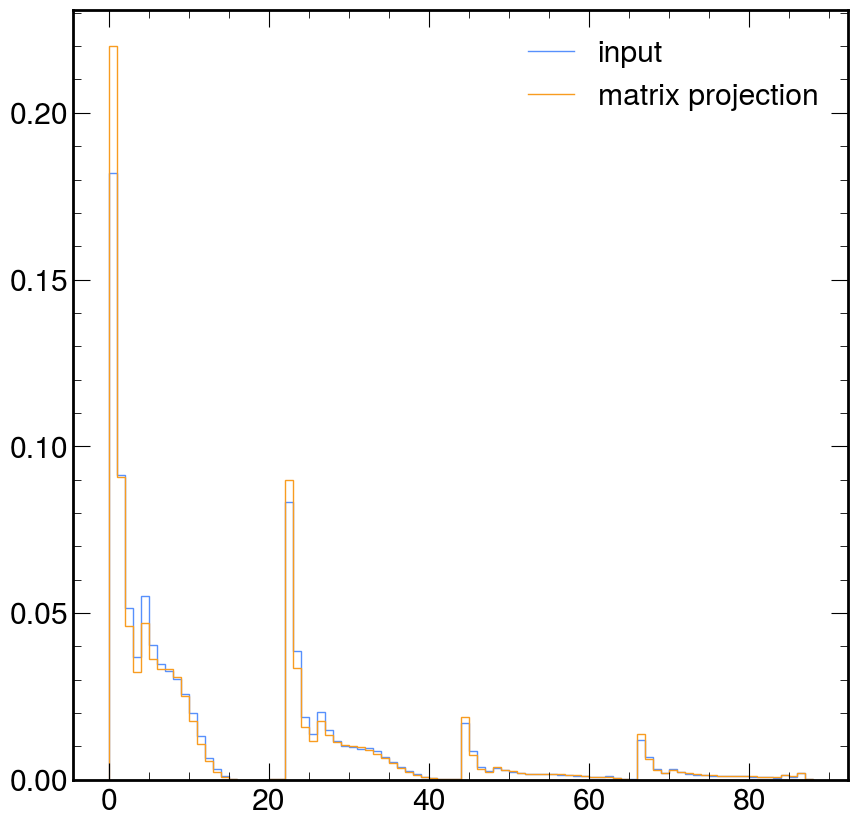

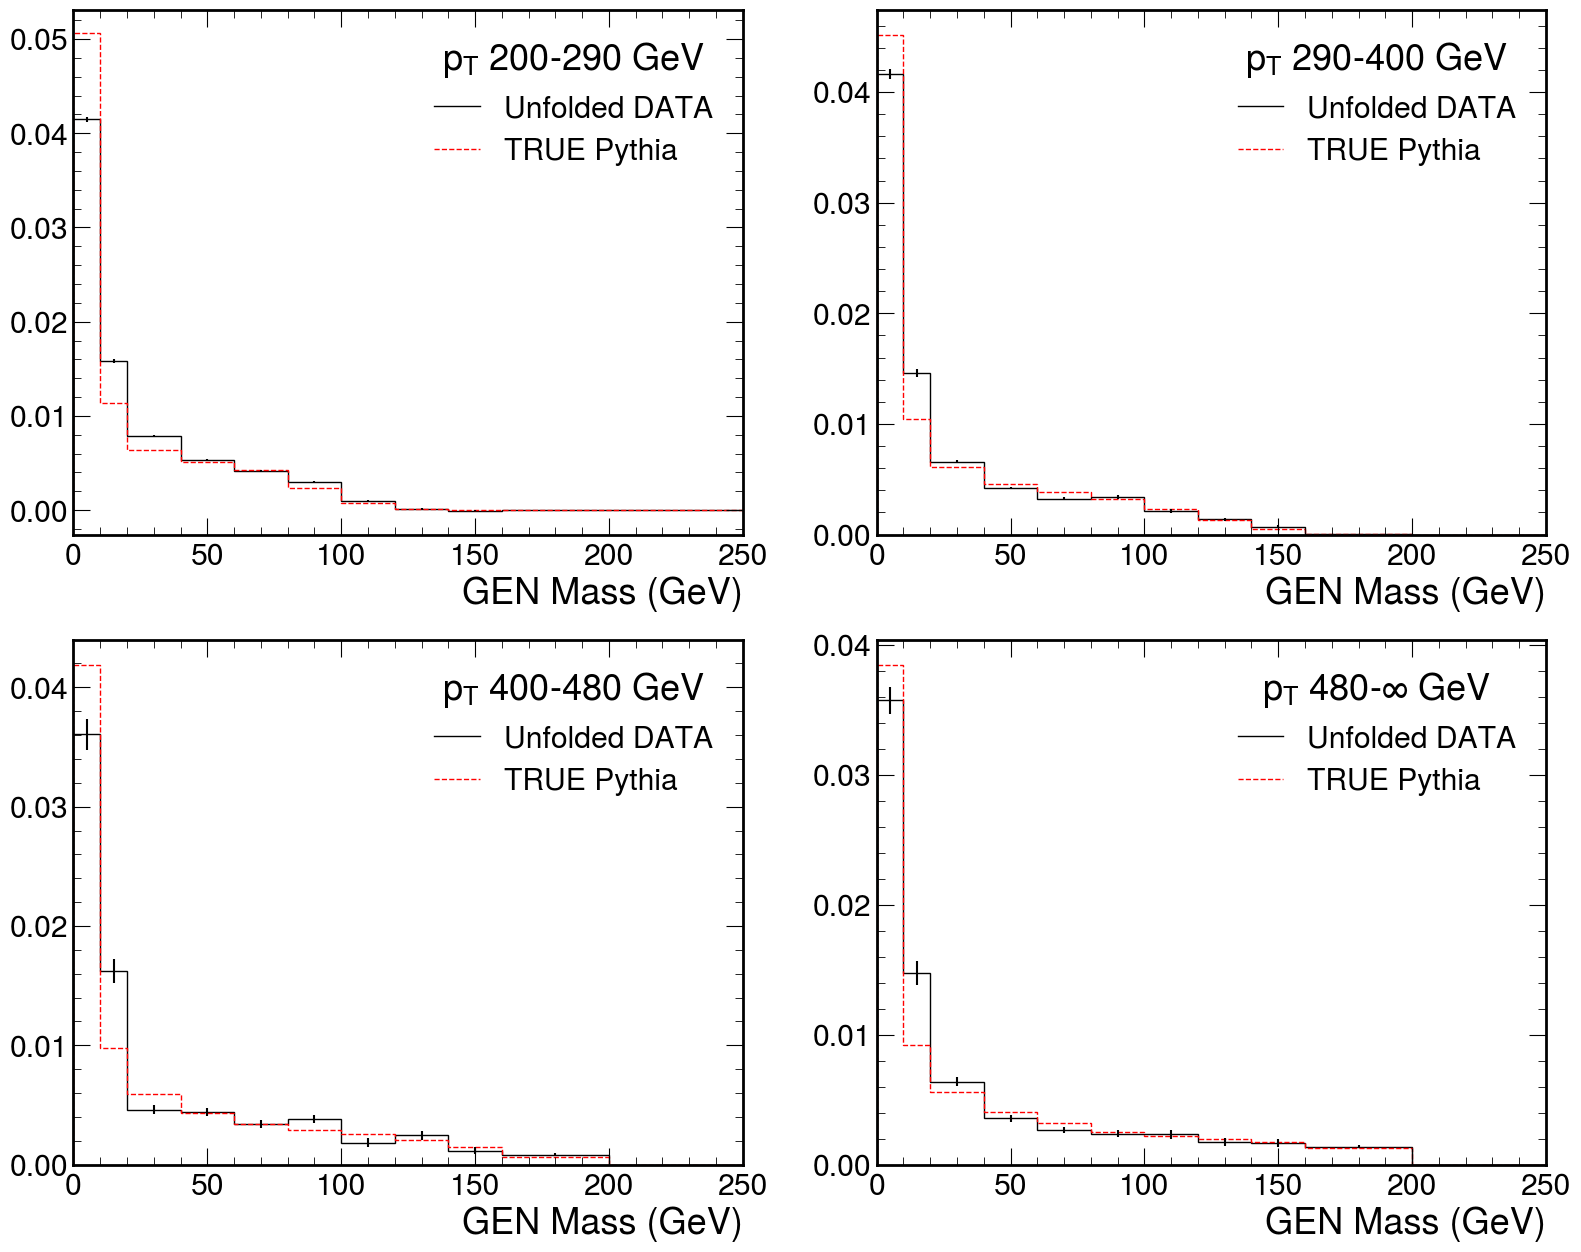

Warning in <TROOT::Append>: Replacing existing TH1: M (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: htrue (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: htruef (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MJES_AbsoluteMPFBiasUp (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 88 input bins and 44 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #45
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing signal regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfoldDensity::ScanSURE>: logtau=-8.000000 Chi2A=35

In [37]:
unfold_driver.unfolder.perform_unfold()
unfold_driver.unfolder.plot_unfolded()